# Train models in jupyter notebook

## Alternatives: train from the terminal:

After installing reflectorch by

```
cd reflectorch
pip install -e .
```

And run
```
python -m reflectorch.train name_of_your_config
```

For training on a Maxwell cluster:

```
python -m reflectorch.train_on_cluster name_of_your_config
```

## Train here

### Load trainer

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

In [2]:
from reflectorch import *

In [3]:
trainer = get_trainer_by_name('l2q256_absorption_1', load_weights=False)

Model l2q256_absorption_1 loaded. Number of parameters: 2.77 M


### Generate data to look at it

In [4]:
data = trainer.loader.get_batch(16)

In [6]:
data['scaled_noisy_curves']

tensor([[ 0.4837,  0.4885,  0.4851,  ..., -0.2548, -0.2687, -0.2808],
        [ 0.4984,  0.4962,  0.4955,  ...,  0.1401,  0.1368,  0.1211],
        [ 0.4907,  0.4935,  0.4875,  ...,  0.0850,  0.0876,  0.0797],
        ...,
        [ 0.4773,  0.4587,  0.4654,  ..., -0.1292, -0.1220, -0.1497],
        [ 0.4924,  0.4991,  0.4955,  ...,  0.1346,  0.1437,  0.1319],
        [ 0.4712,  0.4703,  0.4626,  ...,  0.1320,  0.1306,  0.1220]],
       device='cuda:0', dtype=torch.float64)

In [25]:
data.keys()

dict_keys(['params', 'scaled_params', 'q_values', 'scaled_noisy_curves'])

In [28]:
data['params'].min_bounds.shape

torch.Size([16, 11])

In [29]:
data['params'].max_bounds.shape

torch.Size([16, 11])

In [30]:
data['params'].parameters.shape

torch.Size([16, 11])

In [32]:
data['params'].thicknesses, data['params'].roughnesses, data['params'].slds

(tensor([[107.2089, 279.7525],
         [ 76.5930, 113.3578],
         [ 44.2153, 179.4191],
         [285.0251, 281.0495],
         [182.2545, 187.9111],
         [124.2139, 202.3760],
         [ 84.9420, 181.5449],
         [201.7252, 215.2941],
         [253.7039, 227.9683],
         [242.4407, 227.2404],
         [246.6559, 238.9463],
         [182.5407,   3.0906],
         [235.6653,  12.6284],
         [151.0319, 188.7432],
         [109.4010,   6.8993],
         [236.6787,  56.4952]], device='cuda:0', dtype=torch.float64),
 tensor([[36.6762, 16.4953, 20.3261],
         [34.2549,  2.4727, 32.3022],
         [ 8.1141, 26.3169, 16.9108],
         [35.7232, 23.0821, 21.3446],
         [ 9.9060, 30.6372, 14.3654],
         [10.4239, 26.9326,  8.5304],
         [17.9925, 27.9932, 29.2585],
         [26.2682, 25.2877,  7.7263],
         [18.9718, 38.9549, 37.9287],
         [20.4378, 13.6549, 29.3978],
         [ 3.0743, 19.5579, 30.2721],
         [20.6129,  0.1587,  1.5042],
        

In [15]:
trainer.loader.intensity_noise??

In [40]:
trainer.loader.intensity_noise.poisson_noise.relative_errors = [0.1, 0.1]

In [42]:
data = trainer.loader.get_batch(16)


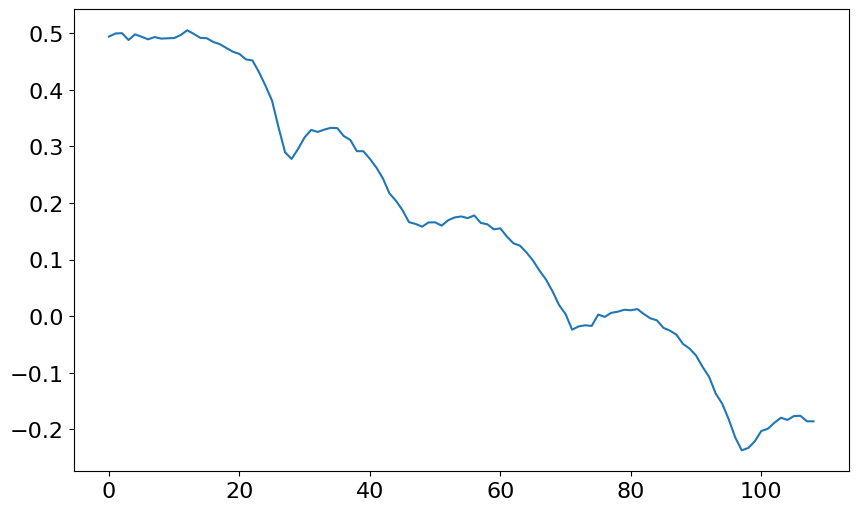

In [43]:
plt.plot(data['scaled_noisy_curves'][1].cpu().numpy())

### train

In [33]:
from reflectorch.extensions.jupyter import JPlotLoss

In [38]:
SAVED_MODELS_DIR

PosixPath('/home/vladimir/PycharmProjects/giwaxs_detector/XRR ideas/reflectorch/saved_models')

In [44]:
trainer.set_lr(1e-4)

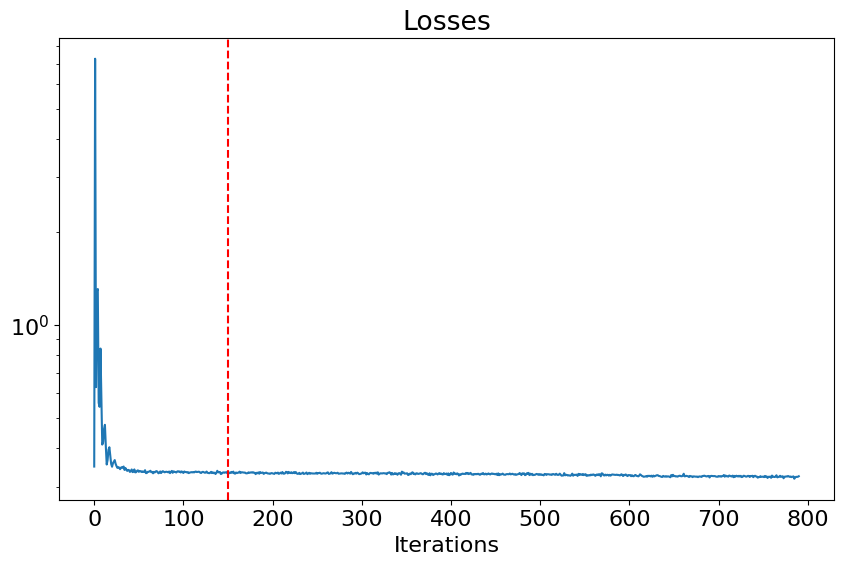

Loss = 3.23e-01:  12%|█▏        | 232/2000 [00:49<06:15,  4.71it/s]


KeyboardInterrupt: 

In [45]:
trainer.train(2000, callbacks=(JPlotLoss(50, ), StepLR(2000, 0.9, last_epoch=8000), SaveBestModel(str(SAVED_MODELS_DIR / 'l2q256_absorption_1.pt'), 50, )))

In [36]:
trainer.set_lr(5e-4)

# test

In [ ]:
import torch

In [62]:
data = trainer.loader.get_batch(16)  # generate a test batch of 16 samples

In [65]:
scaled_target_params = trainer.loader.prior_sampler.scale_params(data['params'])  # scale target params and target bounds

In [66]:
scaled_target_params.shape

torch.Size([16, 33])

In [93]:
n = data['params'].num_params
n

11

In [67]:
scaled_params = scaled_target_params[..., :n]  # scaled target params
scaled_bounds = scaled_target_params[..., n:]  # scaled target bounds

How to scale / restore curves?

In [96]:
noisy_curves = trainer.loader.curves_scaler.restore(data['scaled_noisy_curves'])
assert torch.allclose(data['scaled_noisy_curves'], trainer.loader.curves_scaler.scale(noisy_curves))

The model receives as an input scaled curves and scaled bounds (prior knowledge). So we have to concatenate it:

In [69]:
scaled_input = torch.cat([data['scaled_noisy_curves'], scaled_bounds], dim=-1)

Ok, let's get some predictions:

In [71]:
with torch.no_grad():
    trainer.model.eval()
    scaled_predictions = trainer.model(scaled_input.float())

In [74]:
scaled_predictions = torch.cat([scaled_predictions, scaled_bounds], dim=-1)

In [75]:
restored_predictions = trainer.loader.prior_sampler.restore_params(scaled_predictions)

In [76]:
restored_predictions

BasicParams(batch_size=16, max_layer_num=2, device=cuda:0)

In [80]:
torch.allclose(restored_predictions.min_bounds, data['params'].min_bounds)

True

In [81]:
restored_predictions.parameters - data['params'].parameters

tensor([[-2.3761e-01, -1.4345e-01,  4.9694e-02, -2.8350e-02, -4.5447e-01,
          5.6642e-03, -1.5084e-01, -3.2617e-04,  5.5438e-01,  9.1900e-03,
         -6.4395e-03],
        [-1.9933e+01,  6.4951e-03, -4.8713e-01,  1.9233e-01,  4.4179e-03,
         -1.7175e-02,  4.2519e-03,  4.1519e-03,  1.6623e-02, -2.3594e-02,
         -2.4575e-03],
        [ 1.6159e+00,  1.3538e-03,  6.7444e-03,  4.2399e-02,  1.8735e-02,
         -9.4798e-03,  1.8697e+00,  1.6597e-01, -3.5647e-01,  1.6935e+00,
         -5.1368e-03],
        [-9.9227e+00,  3.9176e-02,  3.0434e-03,  7.9222e-02,  2.7435e+00,
         -7.8572e-01, -7.5917e-03,  9.7844e-02,  3.8075e-02,  2.5181e-02,
         -4.8922e-03],
        [ 7.0287e-02, -1.1708e-02,  1.1570e-02, -2.6384e+00, -2.0942e+00,
          2.1116e-02,  1.5497e-02, -4.8139e-03,  8.3828e-02, -1.0895e-03,
         -5.5909e-03],
        [ 5.2893e+00, -2.4317e-03, -6.6289e-03,  7.0548e-02,  1.4787e-01,
          1.1543e-01,  2.8180e-03,  4.3314e-01,  4.3723e-02,  3.6330e-0

Calculate curves from params:

In [85]:
real_curves = data['params'].reflectivity(trainer.loader.q_generator.q)

In [82]:
predicted_curves = restored_predictions.reflectivity(trainer.loader.q_generator.q)

In [83]:
predicted_curves.shape

torch.Size([16, 109])

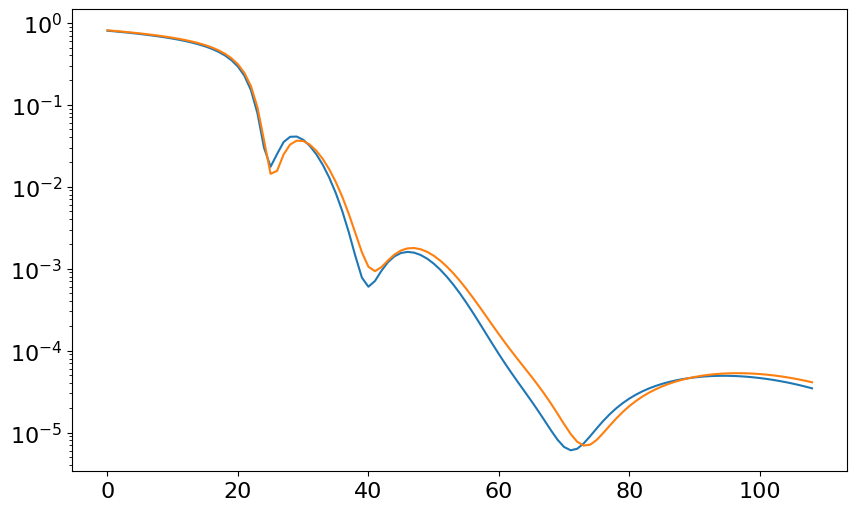

In [98]:
idx = 2
plt.semilogy(real_curves[idx].cpu().numpy())
plt.semilogy(predicted_curves[idx].cpu().numpy())
